In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# **1. Loading Libraries and Data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, ttest_ind
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')

# Display the first few rows of the data
print(df.head())

   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0  


# **2. Checking Data Types and Missing Values**

In [4]:
# Check data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
None


In [5]:
# Check for missing values
print(df.isnull().sum())

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64


# **3. Descriptive Statistics**

In [6]:
# Descriptive statistics for numerical columns
print(df.describe())

                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39

In [7]:
# Distribution of the target variable (rainfall)
print(df['rainfall'].value_counts())

rainfall
1    1650
0     540
Name: count, dtype: int64


# **4. Data Distribution**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Histograms for numerical columns
    </font>
</div>

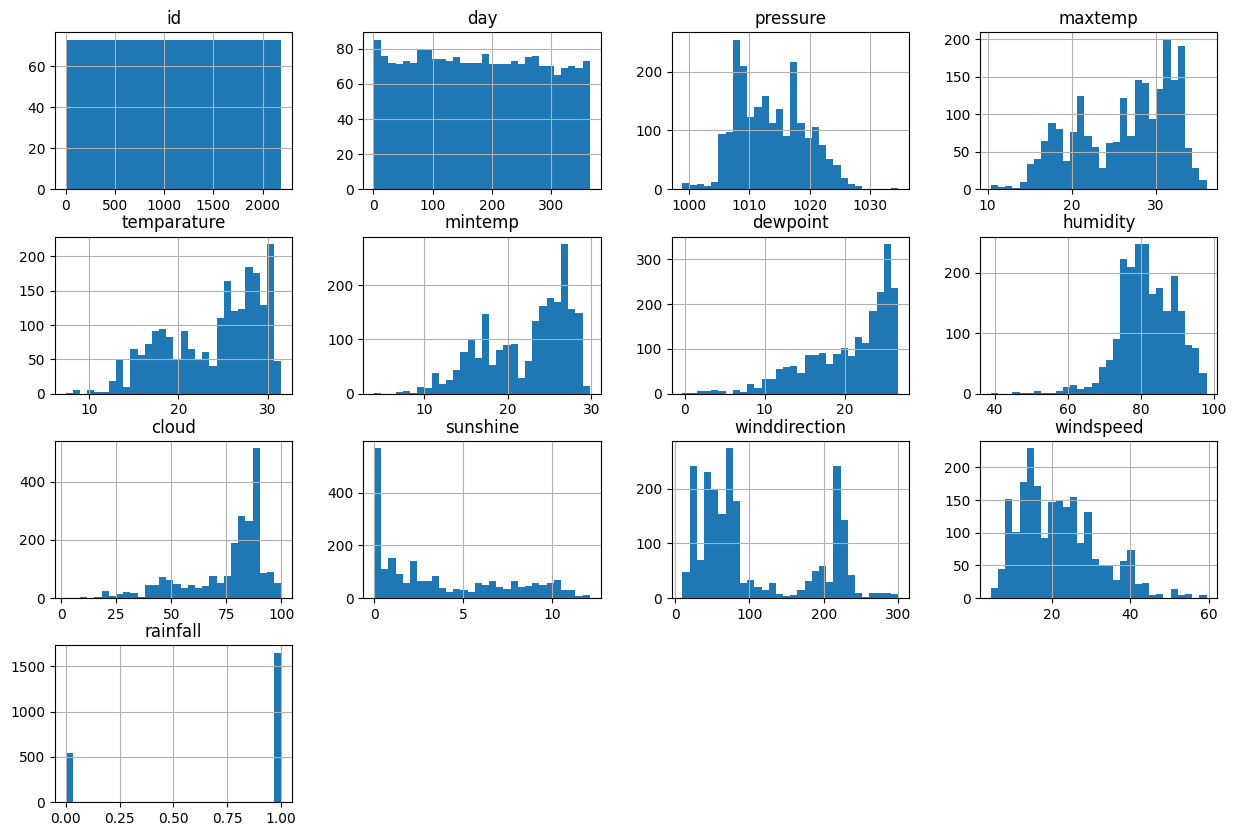

In [8]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Box plots to identify outliers
    </font>
</div>

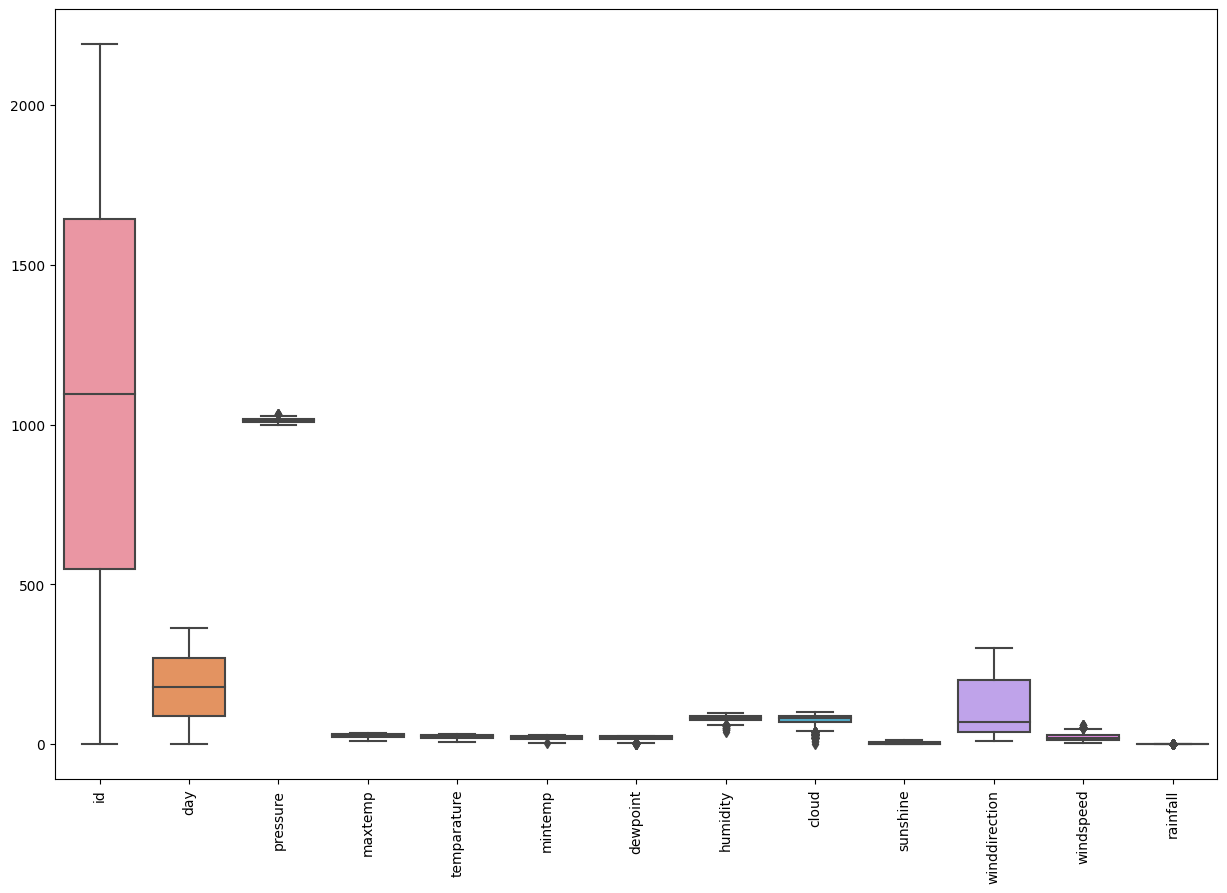

In [9]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Bar plot for the target variable (rainfall)
    </font>
</div>

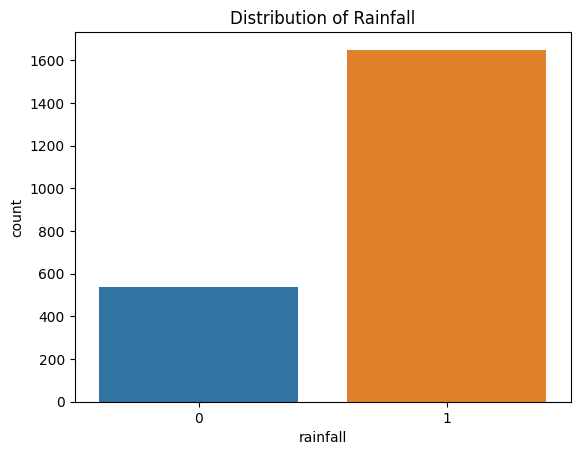

In [10]:
sns.countplot(x='rainfall', data=df)
plt.title('Distribution of Rainfall')
plt.show()

# **5. Correlation Analysis**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Display the correlation matrix as a heatmap
    </font>
</div>

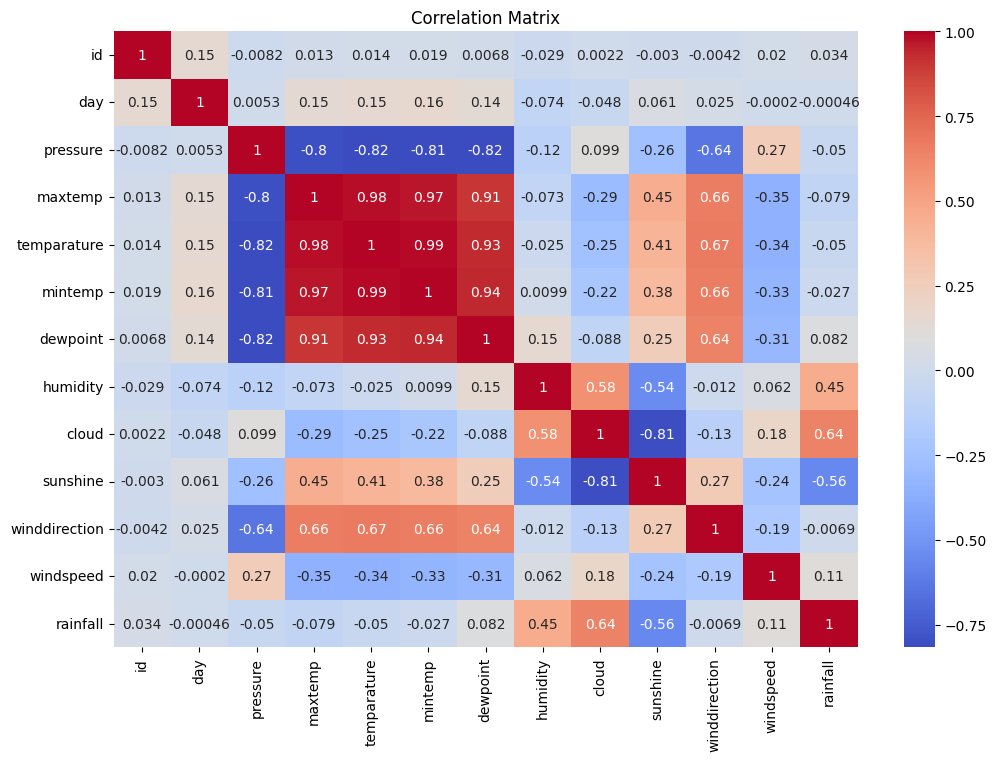

In [11]:
# Calculate the correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **6. Time Series Analysis**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Trend of pressure over time
    </font>
</div>

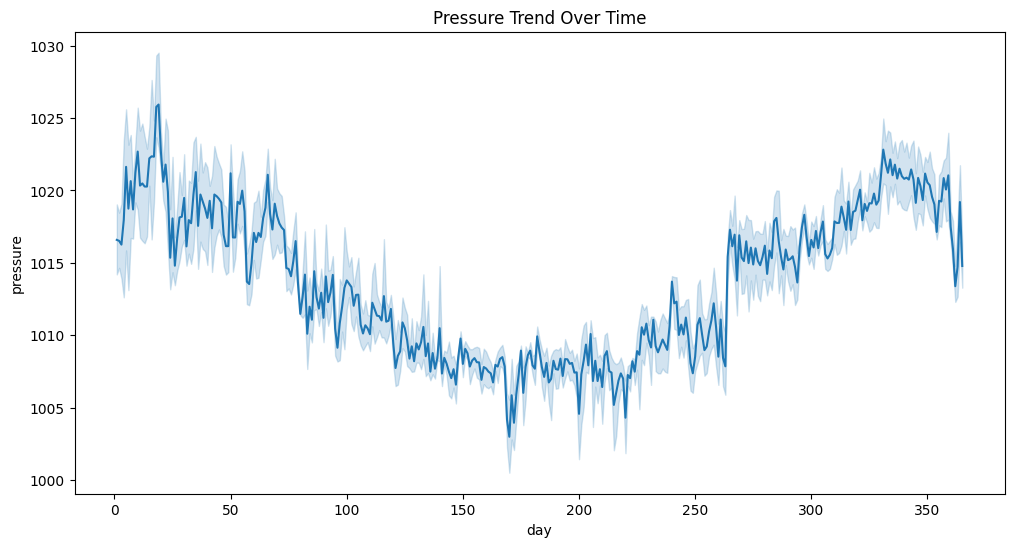

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='pressure', data=df)
plt.title('Pressure Trend Over Time')
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Trend of temperature over time
    </font>
</div>

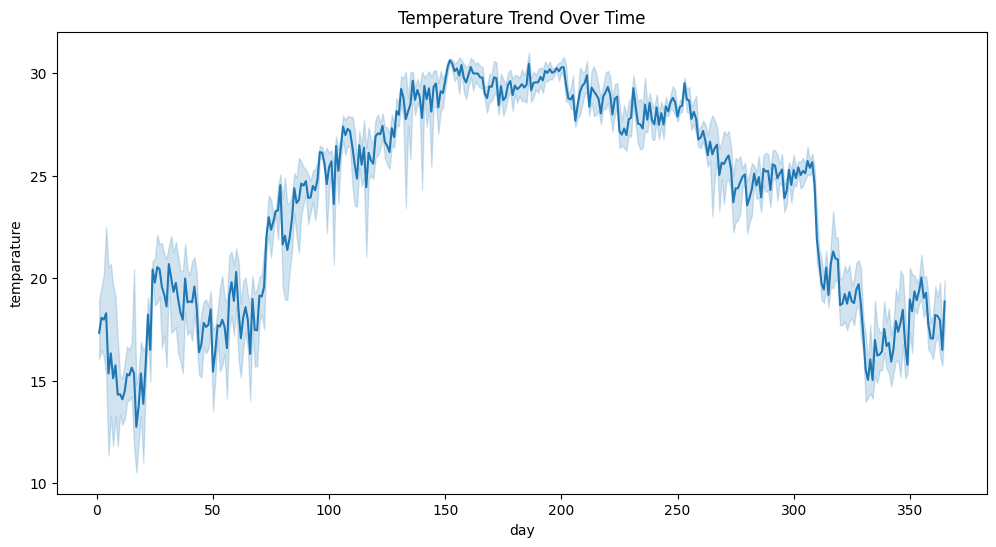

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='temparature', data=df)
plt.title('Temperature Trend Over Time')
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Trend of rainfall over time
    </font>
</div>

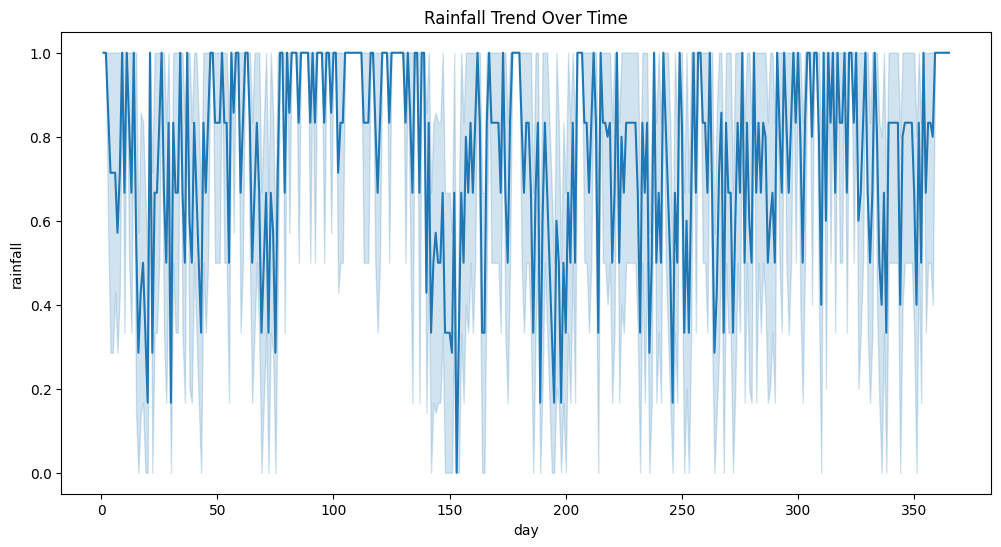

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='rainfall', data=df)
plt.title('Rainfall Trend Over Time')
plt.show()

# **7. Feature Engineering**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Create a seasonal feature (season)
    </font>
</div>

In [15]:
def get_season(day):
    if day <= 90:
        return 'Winter'
    elif day <= 180:
        return 'Spring'
    elif day <= 270:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['day'].apply(get_season)

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Display the distribution of seasons
    </font>
</div>

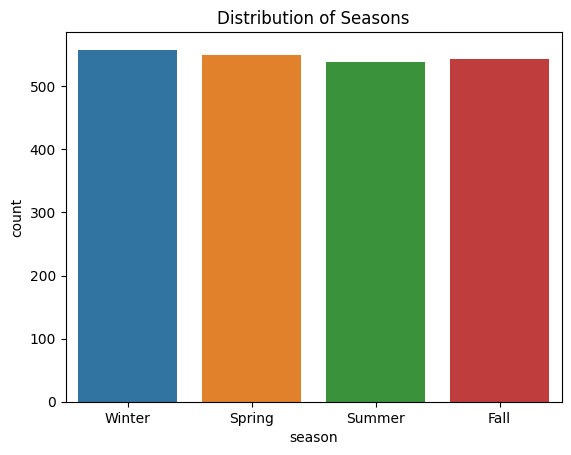

In [16]:
sns.countplot(x='season', data=df)
plt.title('Distribution of Seasons')
plt.show()

# **8. Target Variable Analysis**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Compare pressure between rainy and non-rainy days
    </font>
</div>

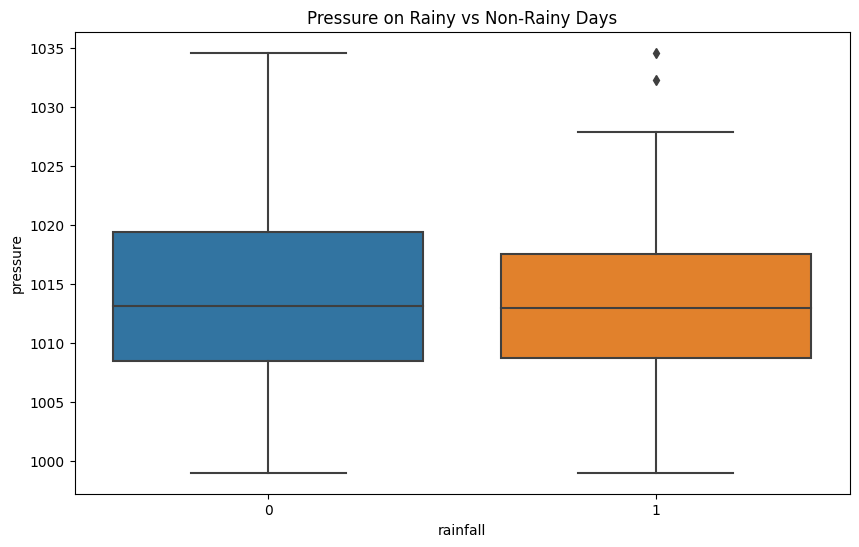

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='rainfall', y='pressure', data=df)
plt.title('Pressure on Rainy vs Non-Rainy Days')
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Compare humidity between rainy and non-rainy days
    </font>
</div>

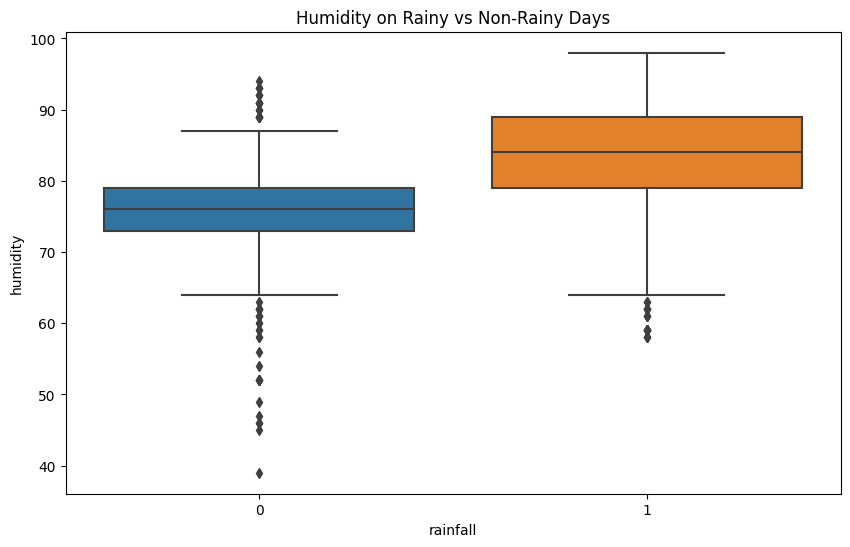

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='rainfall', y='humidity', data=df)
plt.title('Humidity on Rainy vs Non-Rainy Days')
plt.show()

# **9. Outlier Detection**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Calculate Z-scores for numerical columns
    </font>
</div>

In [19]:
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# Identify outliers (Z-score > 3)
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 80


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Display rows with outliers
    </font>
</div>

In [20]:
outlier_rows = df[outliers]
print("Outlier rows:")
print(outlier_rows)

Outlier rows:
        id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
4        4    5    1021.8     21.3         18.4     15.2       9.6      52.0   
6        6    7    1022.8     19.5         18.4     15.3      11.3      56.0   
7        7    8    1019.7     15.8         13.6     12.7      11.8      96.0   
16      16   17    1022.5     16.3         13.1     11.4       2.0      79.0   
17      17   18    1034.6     17.5         16.2     14.1      11.8      68.0   
...    ...  ...       ...      ...          ...      ...       ...       ...   
1892  1892   68    1016.8     23.1         18.4     17.2      20.5      68.0   
2080  2080  256    1007.3     31.2         28.0     26.2      25.0      86.0   
2092  2092  268    1013.7     29.2         25.3     23.1      20.7      77.0   
2155  2155  331    1020.4     17.4         15.2     14.0      -0.3      45.0   
2156  2156  332    1022.4     19.2         16.7     13.7       3.5      70.0   

      cloud  sunshine  wi

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Cap outliers at the 99th percentile and floor at the 1st percentile
    </font>
</div>

In [21]:
for col in df.select_dtypes(include=[np.number]):
    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Remove outliers
    </font>
</div>

In [22]:
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# Identify outliers (Z-score > 3)
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 76


In [23]:
df = df[~outliers]
print(f"Data after removing outliers: {df.shape}")

Data after removing outliers: (2114, 14)


# **10. Data Visualization**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Pair plots for selected variables
    </font>
</div>

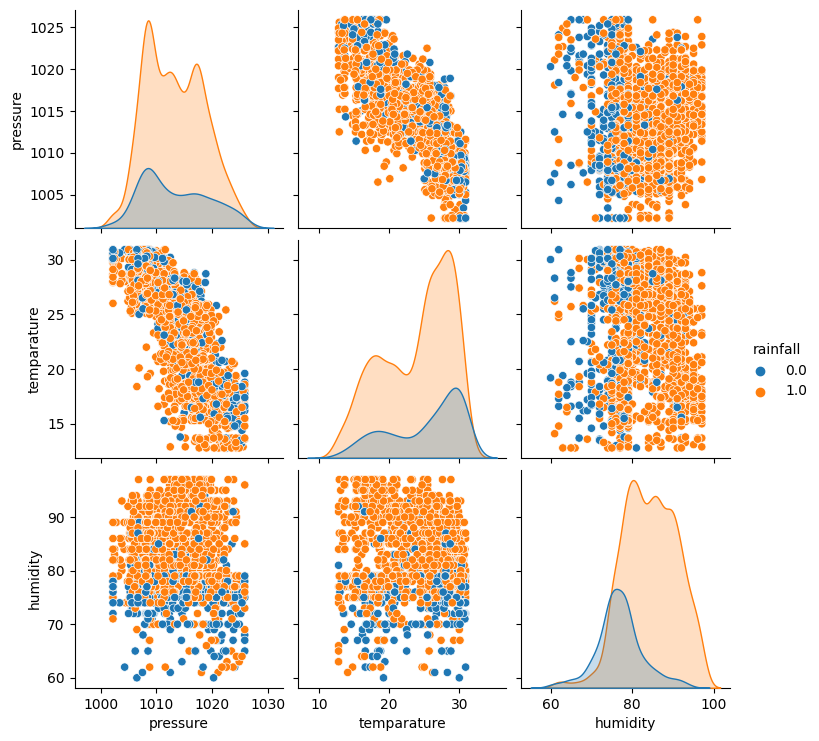

In [24]:
sns.pairplot(df[['pressure', 'temparature', 'humidity', 'rainfall']], hue='rainfall')
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Scatter plot of temperature vs humidity
    </font>
</div>

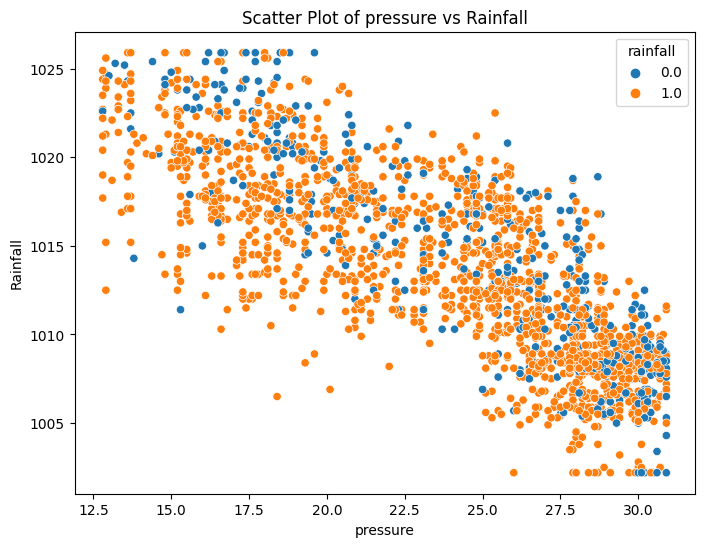

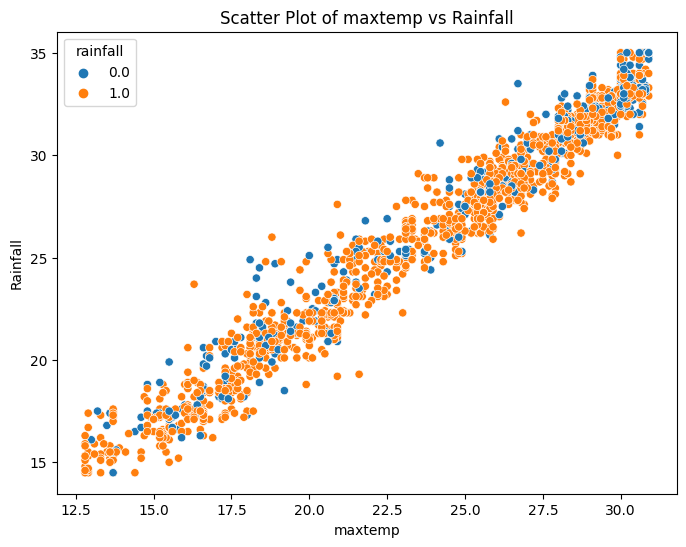

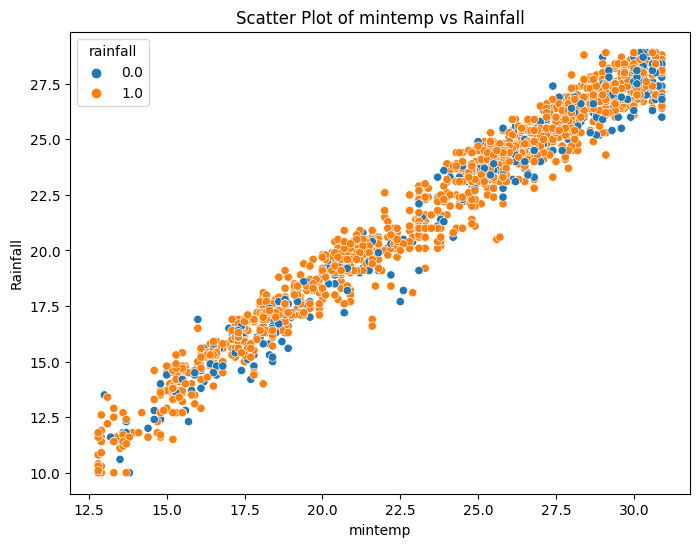

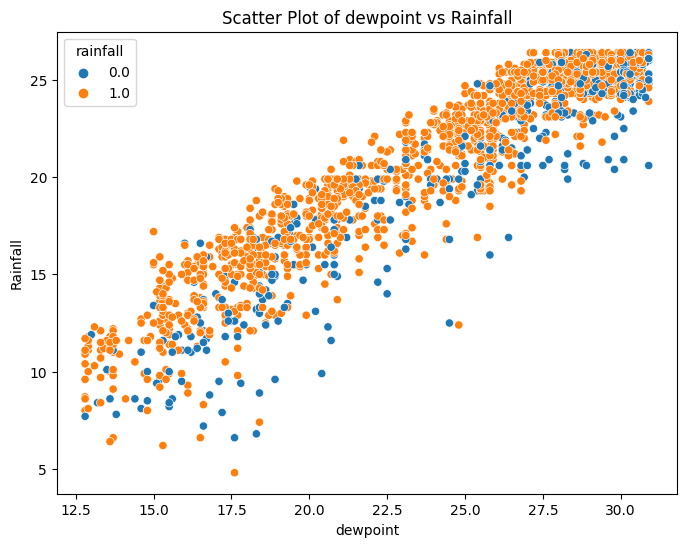

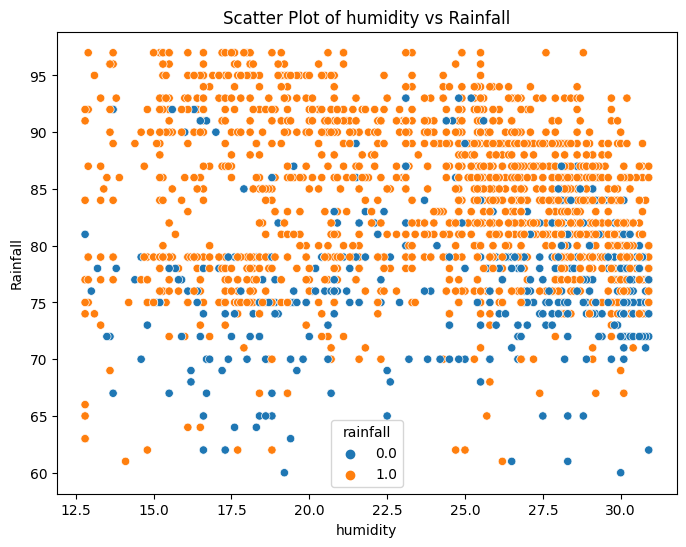

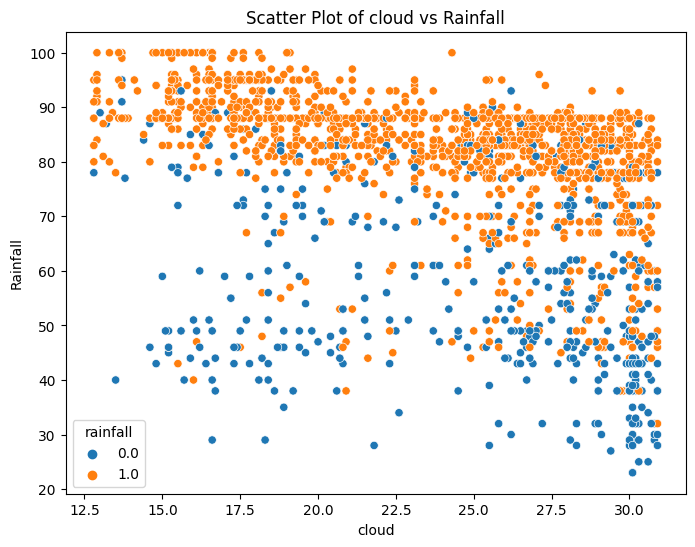

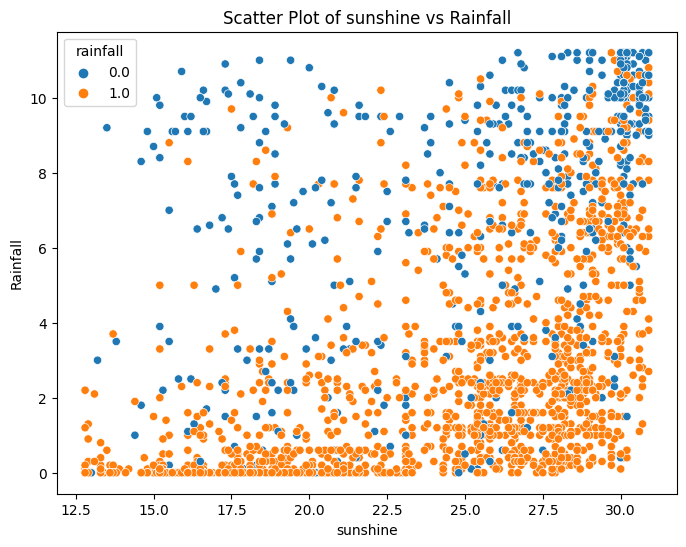

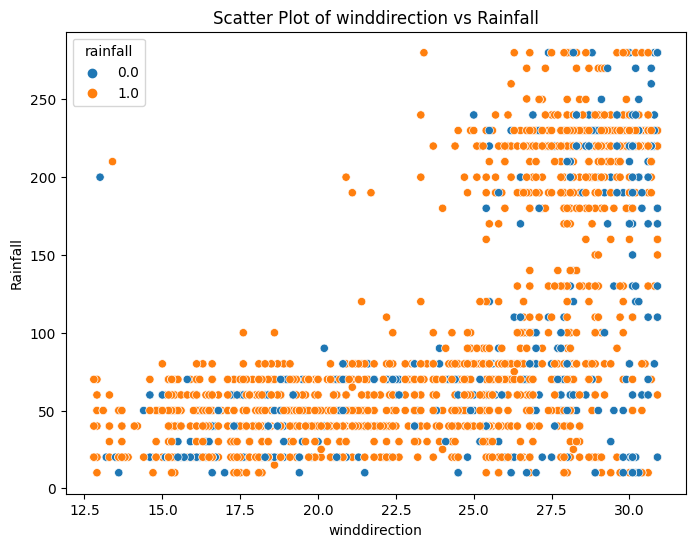

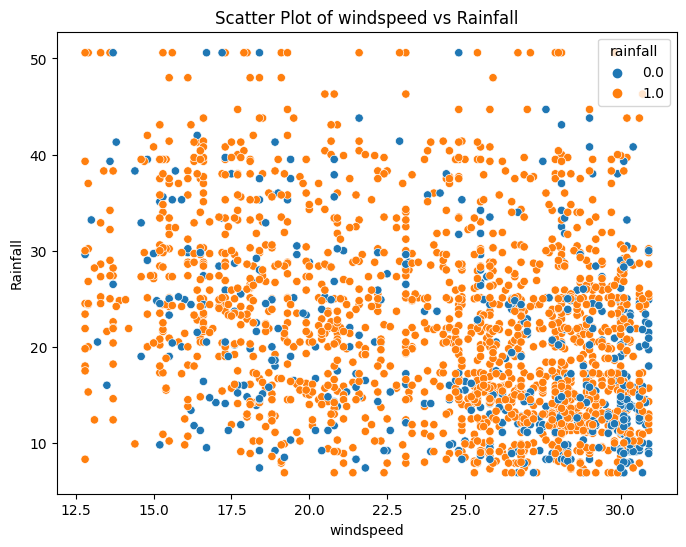

In [25]:
columns = ['pressure', 'maxtemp', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

for col in columns:
    plt.figure(figsize=(8, 6)) 
    sns.scatterplot(x='temparature', y=col, data=df, hue='rainfall')
    plt.title(f'Scatter Plot of {col} vs Rainfall') 
    plt.xlabel(col) 
    plt.ylabel('Rainfall') 
    plt.show()  

# **11. Hypothesis Testing**

In [26]:
# T-test for pressure between rainy and non-rainy days
rainy_pressure = df[df['rainfall'] == 1]['pressure']
non_rainy_pressure = df[df['rainfall'] == 0]['pressure']
t_stat, p_value = ttest_ind(rainy_pressure, non_rainy_pressure)
print(f"T-test for pressure: t-statistic = {t_stat}, p-value = {p_value}")

T-test for pressure: t-statistic = -0.37321870759220427, p-value = 0.709023128755048


# **12. Dimensionality Reduction (PCA)**

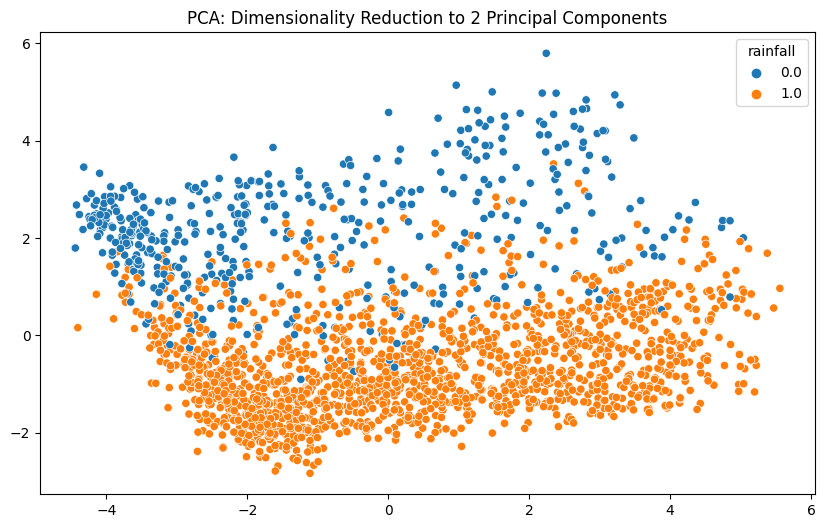

In [27]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['rainfall'])
plt.title('PCA: Dimensionality Reduction to 2 Principal Components')
plt.show()

# **13. Clustering (K-Means)**

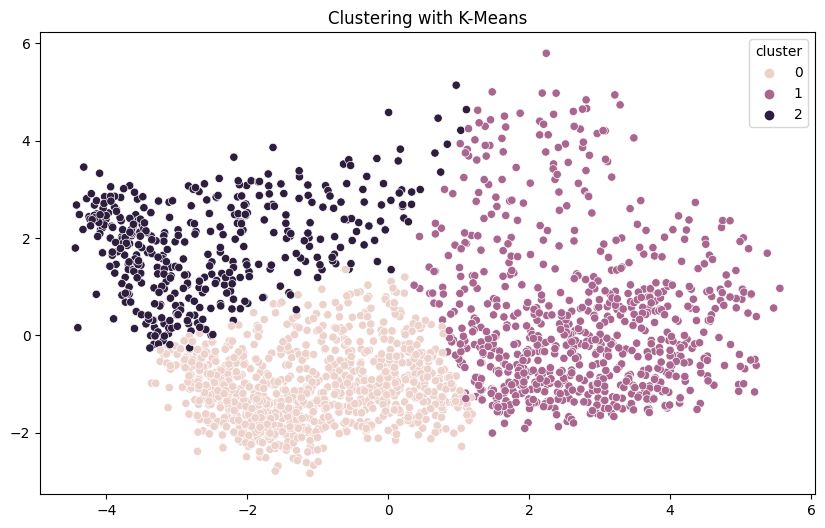

In [28]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['cluster'])
plt.title('Clustering with K-Means')
plt.show()

# **14. Data Preparation**

In [29]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,season,cluster
0,21.89,4.0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1.0,Winter,1
1,21.89,4.0,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1.0,Winter,1
2,21.89,4.0,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1.0,Winter,1
3,21.89,4.0,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1.0,Winter,1
5,21.89,6.0,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1.0,Winter,1


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Encode the 'season' column
    </font>
</div>

In [30]:
encoder = LabelEncoder()
df['season'] = encoder.fit_transform(df['season'])

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Separate features and target variable
    </font>
</div>

In [31]:
X = df.drop(columns=['id', 'rainfall'])
y = df['rainfall']

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Split the data into training and testing sets
    </font>
</div>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the train and test sets
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (1691, 13)
The size of the output train data is: (1691,)
The size of the input test data is: (423, 13)
The size of the output test data is: (423,)


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Standardize the train and test data
    </font>
</div>

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print the sizes of the scaled train and test sets
print("The size of the scaled input train data is: {}".format(X_train_scaled.shape))
print("The size of the scaled input test data is: {}".format(X_test_scaled.shape))

The size of the scaled input train data is: (1691, 13)
The size of the scaled input test data is: (423, 13)


# **15. Define models and their hyperparameter grids**

Tuning RF...
Tuning SVM...
Tuning LR...
Tuning KNN...
Tuning NB...
Tuning GB...
Tuning XGB...
Tuning LGBM...
[LightGBM] [Info] Number of positive: 1294, number of negative: 397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1491
[LightGBM] [Info] Number of data points in the train set: 1691, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.765228 -> initscore=1.181557
[LightGBM] [Info] Start training from score 1.181557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

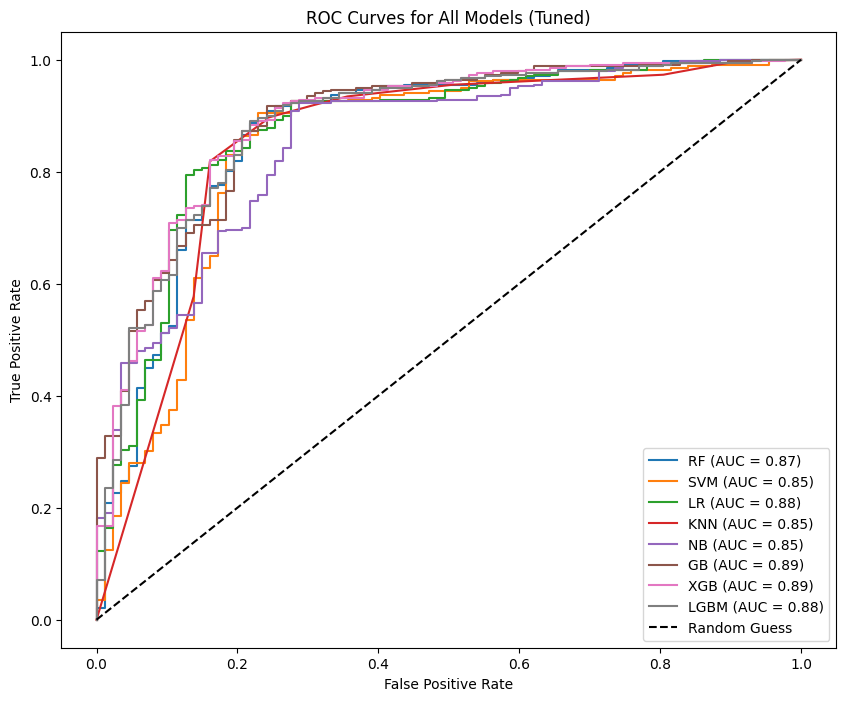

      Accuracy Precision    Recall  F1-Score   ROC-AUC  \
RF    0.881797  0.933333  0.916667  0.924925  0.872742   
SVM   0.881797  0.928144  0.922619  0.925373  0.847804   
LR     0.87234  0.914706  0.925595  0.920118  0.875992   
KNN    0.87234  0.919643  0.919643  0.919643  0.853038   
NB    0.877069   0.92515  0.919643  0.922388  0.853414   
GB    0.879433  0.922849  0.925595   0.92422  0.890805   
XGB   0.884161  0.930931  0.922619  0.926756  0.891249   
LGBM  0.879433  0.927928  0.919643  0.923767  0.884818   

                                            Best Params  
RF    {'max_depth': 10, 'min_samples_split': 5, 'n_e...  
SVM                           {'C': 1, 'kernel': 'rbf'}  
LR                    {'C': 0.1, 'solver': 'liblinear'}  
KNN            {'n_neighbors': 9, 'weights': 'uniform'}  
NB                                                   {}  
GB    {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...  
XGB   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  
LGBM  {'learn

In [34]:
models = {
    'RF': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'LR': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'NB': {
        'model': GaussianNB(),
        'params': {}
    },
    'GB': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'XGB': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'LGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

result = {}

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

for name, config in models.items():
    print(f"Tuning {name}...")
    model = config['model']
    params = config['params']
    
    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Store results
    y_pred = best_model.predict(X_test_scaled)
    result[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc,
        'Best Params': grid_search.best_params_
    }

# Customize ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models (Tuned)')
plt.legend(loc='lower right')
plt.show()

# Display the results
result_df = pd.DataFrame(result).T    
print(result_df)

# **16. Result**

[LightGBM] [Info] Number of positive: 1294, number of negative: 397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1491
[LightGBM] [Info] Number of data points in the train set: 1691, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.765228 -> initscore=1.181557
[LightGBM] [Info] Start training from score 1.181557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

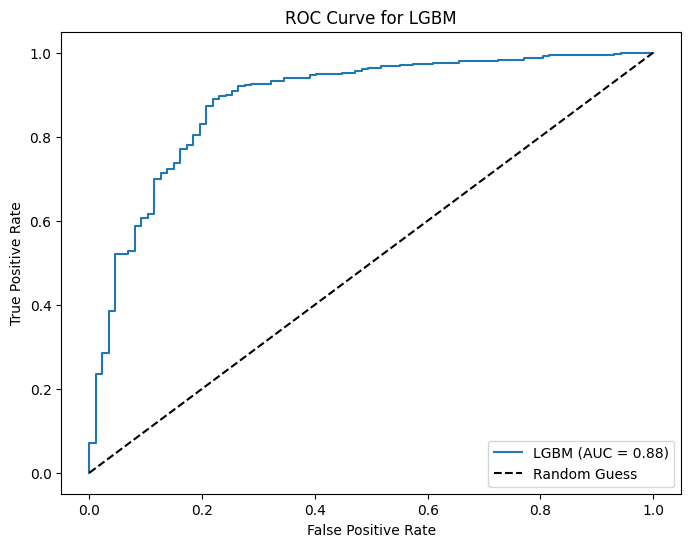

In [35]:
# Define the LGBM model and hyperparameter grid
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

lgbm_model = LGBMClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lgbm_model, lgbm_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_lgbm = grid_search.best_estimator_

# Predict on the test set
y_pred = best_lgbm.predict(X_test_scaled)
y_pred_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LGBM')
plt.legend(loc='lower right')
plt.show()

In [36]:
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
print(test.head())
print(test.isnull().sum())

     id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
1  2191    2    1016.5     17.5         16.5     15.8      15.1      97.0   
2  2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
3  2193    4    1022.9     20.6         17.3     15.2       9.5      75.0   
4  2194    5    1022.2     16.1         13.8      6.4       4.3      68.0   

   cloud  sunshine  winddirection  windspeed  
0   99.0       0.0           50.0       24.3  
1   99.0       0.0           50.0       35.3  
2   96.0       0.0           40.0       16.9  
3   45.0       7.1           20.0       50.6  
4   49.0       9.2           20.0       19.4  
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


In [37]:
test['winddirection'] = test['winddirection'].fillna(method = 'pad')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(test.select_dtypes(include=[np.number]))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=3)
test['cluster'] = kmeans.fit_predict(scaled_data)

test['season'] = test['day'].apply(get_season)
encoder = LabelEncoder()
test['season'] = encoder.fit_transform(test['season'])

X_test = test.drop(columns=['id'])

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [38]:
target = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
target.head()

,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0


In [39]:
y_pred = best_lgbm.predict(X_test_scaled)

In [40]:
test_preds_final = y_pred.copy()
submission_file = test.reset_index()[['id']]
submission_file['Predicted rainfall'] = test_preds_final
submission_file = submission_file.set_index("id")
submission_file.head()

,Predicted rainfall
id,
2190,0.0
2191,0.0
2192,0.0
2193,0.0
2194,0.0


In [41]:
submission_file.to_csv("/kaggle/working/submission.csv")

<div style="background-color: gray; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="6px">
        <a href="https://omidsakaki.ir/">Website</a>
        <br/>
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>